In [146]:
import pybedtools
import pandas as pd
import os,glob
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict,Counter

In [147]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [163]:
save_dir = '../data/processed/fig3_footprinting'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# get chip files 
conservative peaks
and figure out which TFs we have

In [8]:
chip_annon_file = '../data/raw/tf_chip/GM12878/metadata.txt'
chip_annon_df = pd.read_csv(chip_annon_file, sep='\t')
chip_annon_df = chip_annon_df[chip_annon_df['File assembly']=='hg19']
chip_annon_df = chip_annon_df[chip_annon_df['Output type'] =='conservative IDR thresholded peaks']
print(chip_annon_df.shape)
chip_annon_df = chip_annon_df[['File accession', 'Experiment target']]
chip_annon_df[['tf', 'species']] = chip_annon_df['Experiment target'].str.split('-',expand=True)
chip_annon_df['file_path'] = '../data/raw/tf_chip/GM12878/'+chip_annon_df['File accession']+'.bed.gz'
chip_annon_df.reset_index(drop=True,inplace=True)
chip_annon_df

(158, 56)


,File accession,Experiment target,tf,species,file_path
0,ENCFF363BLT,NFYB-human,NFYB,human,../data/raw/tf_chip/GM12878/ENCFF363BLT.bed.gz
1,ENCFF237IPT,TCF12-human,TCF12,human,../data/raw/tf_chip/GM12878/ENCFF237IPT.bed.gz
2,ENCFF511YXY,PBX3-human,PBX3,human,../data/raw/tf_chip/GM12878/ENCFF511YXY.bed.gz
3,ENCFF880NTF,ELF1-human,ELF1,human,../data/raw/tf_chip/GM12878/ENCFF880NTF.bed.gz
4,ENCFF257OPZ,NBN-human,NBN,human,../data/raw/tf_chip/GM12878/ENCFF257OPZ.bed.gz
...,...,...,...,...,...
153,ENCFF752VNM,STAT5A-human,STAT5A,human,../data/raw/tf_chip/GM12878/ENCFF752VNM.bed.gz
154,ENCFF005LCQ,ZFP36-human,ZFP36,human,../data/raw/tf_chip/GM12878/ENCFF005LCQ.bed.gz
155,ENCFF773EXP,CBFB-human,CBFB,human,../data/raw/tf_chip/GM12878/ENCFF773EXP.bed.gz
156,ENCFF340WUW,SMARCA5-human,SMARCA5,human,../data/raw/tf_chip/GM12878/ENCFF340WUW.bed.gz


In [14]:
chip_tfs = set(sorted(chip_annon_df.tf))
len(chip_tfs)

131

In [15]:
annon_df = pd.read_csv('../data/external/HOCOMOCOv11_annotation.csv',index_col=0)
annon_df[['motif_abbr','motif_info']]=annon_df['id'].str.split("_",expand=True)
annon_df_chipsel =  annon_df[annon_df.tf.isin(chip_tfs)]
print(annon_df_chipsel.shape)
annon_df_chipsel[:5]

(65, 4)


,id,tf,motif_abbr,motif_info
8,ARNT_HUMAN.H11MO.0.B,ARNT,ARNT,HUMAN.H11MO.0.B
11,ATF2_HUMAN.H11MO.0.B,ATF2,ATF2,HUMAN.H11MO.0.B
16,BACH1_HUMAN.H11MO.0.A,BACH1,BACH1,HUMAN.H11MO.0.A
19,BATF_HUMAN.H11MO.0.A,BATF,BATF,HUMAN.H11MO.0.A
20,BC11A_HUMAN.H11MO.0.A,BCL11A,BC11A,HUMAN.H11MO.0.A


In [76]:
tfid_to_tf = pd.Series(annon_df_chipsel.tf.values, index=annon_df_chipsel.id.values).to_dict()

In [30]:
tfs_to_check = annon_df_chipsel.tf

chip_annon_df_footsel = chip_annon_df[chip_annon_df.tf.isin(tfs_to_check)]
chip_annon_df_footsel = chip_annon_df_footsel.merge(annon_df_chipsel,how='left',on='tf')
print(chip_annon_df_footsel.shape)
chip_annon_df_footsel[:5]

(80, 8)


,File accession,Experiment target,tf,species,file_path,id,motif_abbr,motif_info
0,ENCFF363BLT,NFYB-human,NFYB,human,../data/raw/tf_chip/GM12878/ENCFF363BLT.bed.gz,NFYB_HUMAN.H11MO.0.A,NFYB,HUMAN.H11MO.0.A
1,ENCFF237IPT,TCF12-human,TCF12,human,../data/raw/tf_chip/GM12878/ENCFF237IPT.bed.gz,HTF4_HUMAN.H11MO.0.A,HTF4,HUMAN.H11MO.0.A
2,ENCFF511YXY,PBX3-human,PBX3,human,../data/raw/tf_chip/GM12878/ENCFF511YXY.bed.gz,PBX3_HUMAN.H11MO.0.A,PBX3,HUMAN.H11MO.0.A
3,ENCFF880NTF,ELF1-human,ELF1,human,../data/raw/tf_chip/GM12878/ENCFF880NTF.bed.gz,ELF1_HUMAN.H11MO.0.A,ELF1,HUMAN.H11MO.0.A
4,ENCFF784PEF,JUNB-human,JUNB,human,../data/raw/tf_chip/GM12878/ENCFF784PEF.bed.gz,JUNB_HUMAN.H11MO.0.A,JUNB,HUMAN.H11MO.0.A


In [31]:
fileacc_to_tfid = pd.Series(chip_annon_df_footsel['id'].values, index=chip_annon_df_footsel['File accession'].values).to_dict()

In [27]:
# sorted(Counter(chip_annon_df_footsel.tf).items(),key=lambda x:x[1],reverse=True)

[('SRF', 3),
 ('IRF3', 3),
 ('TCF12', 2),
 ('STAT1', 2),
 ('EBF1', 2),
 ('MYB', 2),
 ('ZBTB33', 2),
 ('ATF2', 2),
 ('CTCF', 2),
 ('ZNF143', 2),
 ('REST', 2),
 ('IKZF1', 2),
 ('PAX5', 2),
 ('NFYB', 1),
 ('PBX3', 1),
 ('ELF1', 1),
 ('JUNB', 1),
 ('ETS1', 1),
 ('ELK1', 1),
 ('ESRRA', 1),
 ('MEF2B', 1),
 ('IRF4', 1),
 ('ZEB1', 1),
 ('STAT3', 1),
 ('RXRA', 1),
 ('KLF5', 1),
 ('MXI1', 1),
 ('BHLHE40', 1),
 ('MAX', 1),
 ('RUNX3', 1),
 ('NR2C1', 1),
 ('SPI1', 1),
 ('YY1', 1),
 ('E2F4', 1),
 ('USF1', 1),
 ('CUX1', 1),
 ('TBP', 1),
 ('NR2F1', 1),
 ('NR2C2', 1),
 ('GABPA', 1),
 ('JUND', 1),
 ('PKNOX1', 1),
 ('RELB', 1),
 ('ARNT', 1),
 ('NFATC1', 1),
 ('NFIC', 1),
 ('HSF1', 1),
 ('MAZ', 1),
 ('NFATC3', 1),
 ('BATF', 1),
 ('MEF2C', 1),
 ('MEF2A', 1),
 ('BACH1', 1),
 ('BCL11A', 1),
 ('TAF1', 1),
 ('CEBPB', 1),
 ('ZNF384', 1),
 ('TBX21', 1),
 ('TCF7', 1),
 ('MAFK', 1),
 ('RFX5', 1),
 ('CREM', 1),
 ('STAT5A', 1),
 ('CBFB', 1),
 ('SMARCA5', 1)]

65 TFs to check, in 80 files multiples of tfs
```
[('SRF', 3),
 ('IRF3', 3),
 ('TCF12', 2),
 ('STAT1', 2),
 ('EBF1', 2),
 ('MYB', 2),
 ('ZBTB33', 2),
 ('ATF2', 2),
 ('CTCF', 2),
 ('ZNF143', 2),
 ('REST', 2),
 ('IKZF1', 2),
 ('PAX5', 2)
 ```

# Read in atac file


In [100]:
atac_bed = pybedtools.BedTool('../data/raw/atac/GM12878/GM12878_rep1-rep2.idr0.05.bfilt.narrowPeak').sort().merge()
len(atac_bed)

57536

# Read in footprinting file

In [18]:
%%time
foot_bed = pybedtools.BedTool('../data/interim/footprinting/GM12878/GM12878_merged_mpbs_pre.bed')
len(foot_bed)

CPU times: user 8.84 s, sys: 38.6 ms, total: 8.87 s
Wall time: 8.88 s


2136711

In [20]:
foot_df = foot_bed.to_dataframe()
foot_df = foot_df[foot_df.name.isin(annon_df_chipsel.id.values)]
print(foot_df.shape)
foot_df[:5]

(124527, 6)


,chrom,start,end,name,score,strand
40,chr1,762958,762974,TAF1_HUMAN.H11MO.0.A,14.629348,+
42,chr1,762956,762968,ZN384_HUMAN.H11MO.0.C,12.116345,+
79,chr1,762961,762975,KLF5_HUMAN.H11MO.0.A,12.578589,+
122,chr1,762995,763009,KLF5_HUMAN.H11MO.0.A,11.233214,+
138,chr1,825940,825960,IRF3_HUMAN.H11MO.0.B,9.829365,-


# get confusion matrix (2x2)

Chip peak + accessible is gold standard

- A = in chip(accessible) & in foot (TP)
- B = not in chip(accessible) & in foot (FP)
- C = in chip(accessible)  & not in foot (FN)
- D = not in chip(accessible)  & not in foot (TN)

```
2x2 matrix looks like:
A | B
-----
C | D
```

In [62]:
chip_annon_df_footsel[:5]

,File accession,Experiment target,tf,species,file_path,id,motif_abbr,motif_info
0,ENCFF363BLT,NFYB-human,NFYB,human,../data/raw/tf_chip/GM12878/ENCFF363BLT.bed.gz,NFYB_HUMAN.H11MO.0.A,NFYB,HUMAN.H11MO.0.A
1,ENCFF237IPT,TCF12-human,TCF12,human,../data/raw/tf_chip/GM12878/ENCFF237IPT.bed.gz,HTF4_HUMAN.H11MO.0.A,HTF4,HUMAN.H11MO.0.A
2,ENCFF511YXY,PBX3-human,PBX3,human,../data/raw/tf_chip/GM12878/ENCFF511YXY.bed.gz,PBX3_HUMAN.H11MO.0.A,PBX3,HUMAN.H11MO.0.A
3,ENCFF880NTF,ELF1-human,ELF1,human,../data/raw/tf_chip/GM12878/ENCFF880NTF.bed.gz,ELF1_HUMAN.H11MO.0.A,ELF1,HUMAN.H11MO.0.A
4,ENCFF784PEF,JUNB-human,JUNB,human,../data/raw/tf_chip/GM12878/ENCFF784PEF.bed.gz,JUNB_HUMAN.H11MO.0.A,JUNB,HUMAN.H11MO.0.A


In [110]:
%%time
results_dict = {}
for idx, row in chip_annon_df_footsel.iterrows():
    print(idx,row.tf,row['File accession'])
    # get chip file
    chip_file = row.file_path
    chip_name = os.path.basename(chip_file).split('.bed.gz')[0]
    chip_bed = pybedtools.BedTool(chip_file).sort().merge()
    chip_atac_bed = chip_bed.intersect(atac_bed)
    # get selected footprinting
    foot_df_tfsel = foot_df[foot_df.name==fileacc_to_tfid[chip_name]]
    foot_bed_tfsel = pybedtools.BedTool.from_dataframe(foot_df_tfsel).sort()
    
    num_chip_peaks = len(chip_bed)
    num_chip_atac_peaks = len(chip_atac_bed)
    num_footprints = len(foot_bed_tfsel)
    
    TP = (chip_atac_bed+foot_bed_tfsel).count() # A
    FP = (foot_bed_tfsel-chip_atac_bed).count() # B
    FN = (chip_atac_bed-foot_bed_tfsel).count() # C
    TN = foot_bed_tfsel.cat(chip_atac_bed).count() # D

    sens = TP/(TP+FN)
    spec = TN/(TN+FP)
    PPV = TP/(TP+FP)
    FDR = 1- PPV
    NPV = TN/(TN+FP)
    acc = (TP+TN)/(TP+TN+FP+FN)
    
    results_dict[row['File accession']] = {'tf': row.tf, 'tfid':row.id,
                            'num_chip_peaks':num_chip_peaks, 'num_chip_atac_peaks':num_chip_atac_peaks,'num_footprints':num_footprints,
                            'TP':TP, 'FP':FP,'FN':FN,'TN':TN,
                'sens':sens,'spec':spec,'PPV':PPV,'NPV':NPV,'FDR':FDR,'acc':acc
    }
#     z = {**x, **y}

0 NFYB ENCFF363BLT
1 TCF12 ENCFF237IPT
2 PBX3 ENCFF511YXY
3 ELF1 ENCFF880NTF
4 JUNB ENCFF784PEF
5 ETS1 ENCFF565SXH
6 ELK1 ENCFF434DKI
7 ESRRA ENCFF077VXQ
8 MEF2B ENCFF006MAM
9 IRF4 ENCFF708VKT
10 STAT1 ENCFF568FPC
11 STAT1 ENCFF680DVR
12 ZEB1 ENCFF621OAS
13 STAT3 ENCFF494DOZ
14 EBF1 ENCFF382VEJ
15 RXRA ENCFF299YDM
16 KLF5 ENCFF762AZG
17 MXI1 ENCFF861YUL
18 MYB ENCFF299VKC
19 MYB ENCFF173YZN
20 TCF12 ENCFF759PVA
21 ZBTB33 ENCFF431XRU
22 BHLHE40 ENCFF006MIL
23 MAX ENCFF407JNK
24 RUNX3 ENCFF147DQK
25 ATF2 ENCFF049KAI
26 NR2C1 ENCFF538XDH
27 SPI1 ENCFF040ZUY
28 SRF ENCFF593FGJ
29 YY1 ENCFF294BZJ
30 IRF3 ENCFF742LLN
31 IRF3 ENCFF880CYV
32 E2F4 ENCFF850MAC
33 ATF2 ENCFF133GHG
34 USF1 ENCFF859GUL
35 CUX1 ENCFF803SFG
36 CTCF ENCFF963PJY
37 TBP ENCFF327NLV
38 NR2F1 ENCFF255HIR
39 ZNF143 ENCFF369JYP
40 NR2C2 ENCFF208TMB
41 EBF1 ENCFF736ACY
42 REST ENCFF936XYD
43 GABPA ENCFF627POZ
44 IKZF1 ENCFF872DIW
45 PAX5 ENCFF969EMZ
46 JUND ENCFF321KTX
47 IRF3 ENCFF169DMC
48 SRF ENCFF703TFD
49 PKNOX1 ENCFF61

In [115]:
result_df = pd.DataFrame.from_dict(results_dict,orient='index')
result_df

,tf,tfid,num_chip_peaks,num_chip_atac_peaks,num_footprints,TP,FP,FN,TN,sens,spec,PPV,NPV,FDR,acc
ENCFF363BLT,NFYB,NFYB_HUMAN.H11MO.0.A,7296,4514,1312,745,458,3769,4970,0.165042,0.915623,0.619285,0.915623,0.380715,0.574834
ENCFF237IPT,TCF12,HTF4_HUMAN.H11MO.0.A,11138,8821,1580,293,1269,8528,10047,0.033216,0.887858,0.187580,0.887858,0.812420,0.513483
ENCFF511YXY,PBX3,PBX3_HUMAN.H11MO.0.A,3170,2722,1101,167,927,2555,3644,0.061352,0.797200,0.152651,0.797200,0.847349,0.522556
ENCFF880NTF,ELF1,ELF1_HUMAN.H11MO.0.A,29061,22523,2278,1491,721,21032,23237,0.066199,0.969906,0.674051,0.969906,0.325949,0.532002
ENCFF784PEF,JUNB,JUNB_HUMAN.H11MO.0.A,28691,14527,1537,962,548,13565,15074,0.066222,0.964921,0.637086,0.964921,0.362914,0.531892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENCFF631JFD,ZNF143,ZN143_HUMAN.H11MO.0.A,11744,8836,460,136,318,8700,9154,0.015392,0.966427,0.299559,0.966427,0.700441,0.507428
ENCFF642JEY,CREM,CREM_HUMAN.H11MO.0.C,26154,21135,663,364,226,20771,21353,0.017223,0.989527,0.616949,0.989527,0.383051,0.508428
ENCFF752VNM,STAT5A,STA5A_HUMAN.H11MO.0.A,8373,7700,671,77,594,7623,8292,0.010000,0.933153,0.114754,0.933153,0.885246,0.504582
ENCFF773EXP,CBFB,PEBB_HUMAN.H11MO.0.C,16609,14996,1734,774,930,14222,15923,0.051614,0.944817,0.454225,0.944817,0.545775,0.524255


In [125]:
results_grouped = result_df.groupby('tf').agg({
    'tfid':'count',
'sens':'mean','spec':'mean','PPV':'mean','acc':'mean'
    
}).sort_values('PPV',ascending=False).reset_index()


In [117]:
result_df[result_df.PPV>.5].sort_values('PPV',ascending=False)

,tf,tfid,num_chip_peaks,num_chip_atac_peaks,num_footprints,TP,FP,FN,TN,sens,spec,PPV,NPV,FDR,acc
ENCFF147DQK,RUNX3,RUNX3_HUMAN.H11MO.0.A,60521,36283,1908,1636,223,34647,36503,0.045090,0.993928,0.880043,0.993928,0.119957,0.522388
ENCFF006MIL,BHLHE40,BHE40_HUMAN.H11MO.0.A,33025,22752,871,583,115,22169,22862,0.025624,0.994995,0.835244,0.994995,0.164756,0.512694
ENCFF294BZJ,YY1,TYY1_HUMAN.H11MO.0.A,32108,24180,854,628,211,23552,24390,0.025972,0.991423,0.748510,0.991423,0.251490,0.512864
ENCFF880NTF,ELF1,ELF1_HUMAN.H11MO.0.A,29061,22523,2278,1491,721,21032,23237,0.066199,0.969906,0.674051,0.969906,0.325949,0.532002
ENCFF482FJT,BATF,BATF_HUMAN.H11MO.0.A,30008,15630,1041,666,351,14964,15978,0.042610,0.978505,0.654867,0.978505,0.345133,0.520792
ENCFF784PEF,JUNB,JUNB_HUMAN.H11MO.0.A,28691,14527,1537,962,548,13565,15074,0.066222,0.964921,0.637086,0.964921,0.362914,0.531892
ENCFF096AKZ,CTCF,CTCF_HUMAN.H11MO.0.A,37803,14400,2737,1661,965,12739,15346,0.115347,0.940837,0.632521,0.940837,0.367479,0.553776
ENCFF363BLT,NFYB,NFYB_HUMAN.H11MO.0.A,7296,4514,1312,745,458,3769,4970,0.165042,0.915623,0.619285,0.915623,0.380715,0.574834
ENCFF963PJY,CTCF,CTCF_HUMAN.H11MO.0.A,36465,14167,2737,1625,1004,12542,15153,0.114703,0.937860,0.618106,0.937860,0.381894,0.553291
ENCFF642JEY,CREM,CREM_HUMAN.H11MO.0.C,26154,21135,663,364,226,20771,21353,0.017223,0.989527,0.616949,0.989527,0.383051,0.508428


In [176]:
result_df.to_csv(os.path.join(save_dir, 'metrics_foot_chip_GM12878.csv'))

In [122]:
id_to_run_pairwise_on = result_df[result_df.PPV>.5].tfid.values

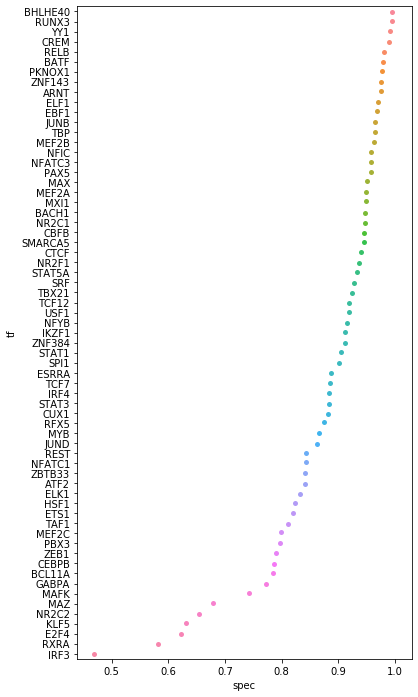

In [139]:
fig = plt.figure(figsize=(6, 12))
sns.stripplot(y = results_grouped.sort_values('spec',ascending=False).tf, x= results_grouped.sort_values('spec',ascending=False).spec)

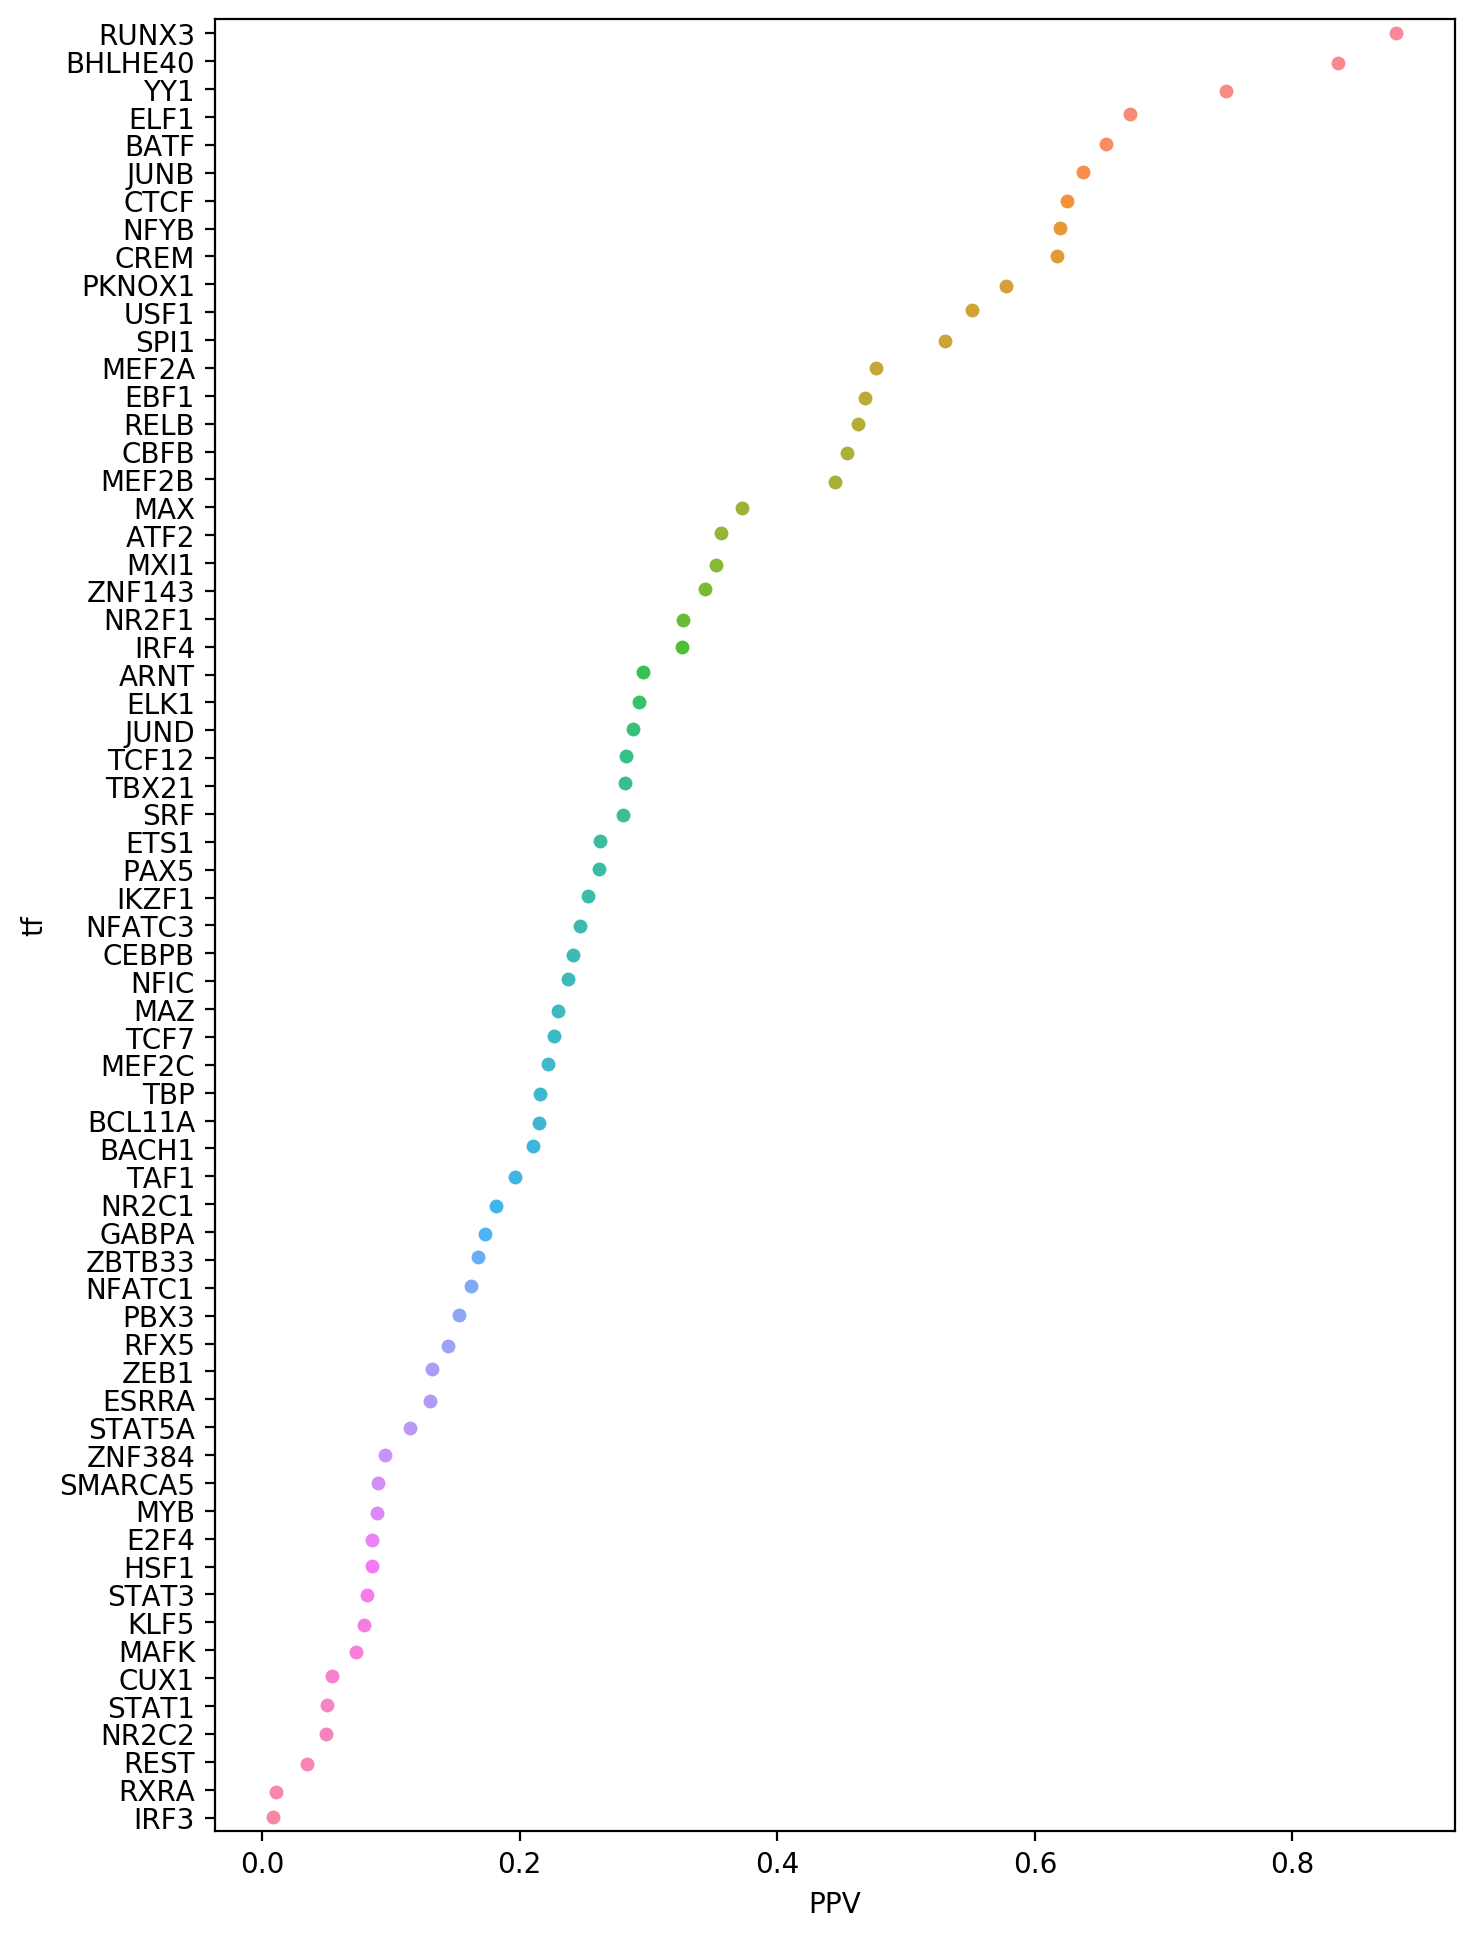

In [174]:
# fig = plt.figure(figsize=(6, 12),dpi=200)
fig,ax = plt.subplots(figsize=(8, 12),dpi=200)

ax = sns.stripplot(y = results_grouped.tf, x= results_grouped.PPV)
plt.savefig(os.path.join(save_dir, 'foot_chip_PPV.pdf'),pad_inches=0.4)

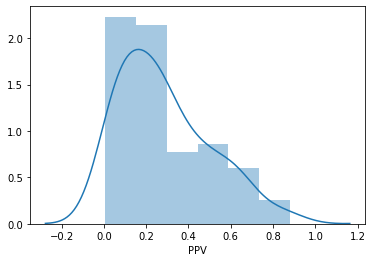

In [113]:
sns.distplot(result_df.PPV)

# create confusion matrix (sscan every chip tf foot tf pair) 
- only do for good id_to_run_pairwise_on

In [81]:
%%time
foot_id_to_foot_bed = {}
for foot_id in fileacc_to_tfid.values():
    # get selected footprinting
    foot_df_tfsel = foot_df[foot_df.name==foot_id]#fileacc_to_tfid[chip_name]]
    foot_bed_tfsel = pybedtools.BedTool.from_dataframe(foot_df_tfsel).sort()
    foot_id_to_foot_bed[foot_id] = foot_bed_tfsel

CPU times: user 1.46 s, sys: 570 ms, total: 2.03 s
Wall time: 2.57 s


In [123]:
%%time
results_dict_pair = {}
for idx, row in chip_annon_df_footsel.iterrows():
    if row.id not in id_to_run_pairwise_on:
        continue
    print(idx,row.tf,row['File accession'])
    # get chip file
    chip_file = row.file_path
    chip_name = os.path.basename(chip_file).split('.bed.gz')[0]
    chip_bed = pybedtools.BedTool(chip_file).sort().merge()
    chip_atac_bed = chip_bed.intersect(atac_bed)
    
    
    for foot_id in fileacc_to_tfid.values():
        if foot_id not in id_to_run_pairwise_on:
            continue
        
        # get selected footprinting      
        foot_bed_tfsel = foot_id_to_foot_bed[foot_id]

        num_chip_peaks = len(chip_bed)
        num_chip_atac_peaks = len(chip_atac_bed)
        num_footprints = len(foot_bed_tfsel)

        TP = (chip_atac_bed+foot_bed_tfsel).count() # A
        FP = (foot_bed_tfsel-chip_atac_bed).count() # B
        FN = (chip_atac_bed-foot_bed_tfsel).count() # C
        TN = foot_bed_tfsel.cat(chip_atac_bed).count() # D

        sens = TP/(TP+FN)
        spec = TN/(TN+FP)
        PPV = TP/(TP+FP)
        FDR = 1- PPV
        NPV = TN/(TN+FP)
        acc = (TP+TN)/(TP+TN+FP+FN)

        results_dict_pair[(row.id, foot_id)] = {'file_acc':chip_name,'chip_tf': row.tf,  'foot_tf':tfid_to_tf[foot_id], 'foot_id':foot_id,
#                                 'num_chip_peaks':num_chip_peaks, 'num_chip_atac_peaks':num_chip_atac_peaks,'num_footprints':num_footprints,
#                                 'TP':TP, 'FP':FP,'FN':FN,'TN':TN,
                    'sens':sens,'spec':spec,'PPV':PPV,'NPV':NPV,'FDR':FDR,'acc':acc
        }
#     z = {**x, **y}

0 NFYB ENCFF363BLT
3 ELF1 ENCFF880NTF
4 JUNB ENCFF784PEF
22 BHLHE40 ENCFF006MIL
24 RUNX3 ENCFF147DQK
25 ATF2 ENCFF049KAI
27 SPI1 ENCFF040ZUY
29 YY1 ENCFF294BZJ
33 ATF2 ENCFF133GHG
34 USF1 ENCFF859GUL
36 CTCF ENCFF963PJY
49 PKNOX1 ENCFF618KHI
59 CTCF ENCFF096AKZ
61 BATF ENCFF482FJT
76 CREM ENCFF642JEY
CPU times: user 1min 22s, sys: 7.27 s, total: 1min 29s
Wall time: 1min 58s


In [132]:
pairwise_df = pd.DataFrame.from_dict(results_dict_pair,orient='index').reset_index()
pairwise_df

,level_0,level_1,file_acc,chip_tf,foot_tf,foot_id,sens,spec,PPV,NPV,FDR,acc
0,NFYB_HUMAN.H11MO.0.A,NFYB_HUMAN.H11MO.0.A,ENCFF363BLT,NFYB,NFYB,NFYB_HUMAN.H11MO.0.A,0.165042,0.915623,0.619285,0.915623,0.380715,0.574834
1,NFYB_HUMAN.H11MO.0.A,ELF1_HUMAN.H11MO.0.A,ENCFF363BLT,NFYB,ELF1,ELF1_HUMAN.H11MO.0.A,0.030572,0.756686,0.060873,0.756686,0.939127,0.509575
2,NFYB_HUMAN.H11MO.0.A,JUNB_HUMAN.H11MO.0.A,ENCFF363BLT,NFYB,JUNB,JUNB_HUMAN.H11MO.0.A,0.011520,0.801632,0.033876,0.801632,0.966124,0.504170
3,NFYB_HUMAN.H11MO.0.A,BHE40_HUMAN.H11MO.0.A,ENCFF363BLT,NFYB,BHLHE40,BHE40_HUMAN.H11MO.0.A,0.017723,0.870427,0.094675,0.870427,0.905325,0.500960
4,NFYB_HUMAN.H11MO.0.A,RUNX3_HUMAN.H11MO.0.A,ENCFF363BLT,NFYB,RUNX3,RUNX3_HUMAN.H11MO.0.A,0.014400,0.775092,0.034085,0.775092,0.965915,0.504802
...,...,...,...,...,...,...,...,...,...,...,...,...
164,CREM_HUMAN.H11MO.0.C,USF1_HUMAN.H11MO.0.A,ENCFF642JEY,CREM,USF1,USF1_HUMAN.H11MO.0.A,0.015283,0.967718,0.308206,0.967718,0.691794,0.505953
165,CREM_HUMAN.H11MO.0.C,CTCF_HUMAN.H11MO.0.A,ENCFF642JEY,CREM,CTCF,CTCF_HUMAN.H11MO.0.A,0.023279,0.913083,0.181751,0.913083,0.818249,0.509685
166,CREM_HUMAN.H11MO.0.C,PKNX1_HUMAN.H11MO.0.B,ENCFF642JEY,CREM,PKNOX1,PKNX1_HUMAN.H11MO.0.B,0.014904,0.974064,0.352744,0.974064,0.647256,0.507197
167,CREM_HUMAN.H11MO.0.C,BATF_HUMAN.H11MO.0.A,ENCFF642JEY,CREM,BATF,BATF_HUMAN.H11MO.0.A,0.020913,0.973845,0.431220,0.973845,0.568780,0.510052


In [ ]:
pairwise_df.pivot('chip_tf','foot_tf',values='PPV')

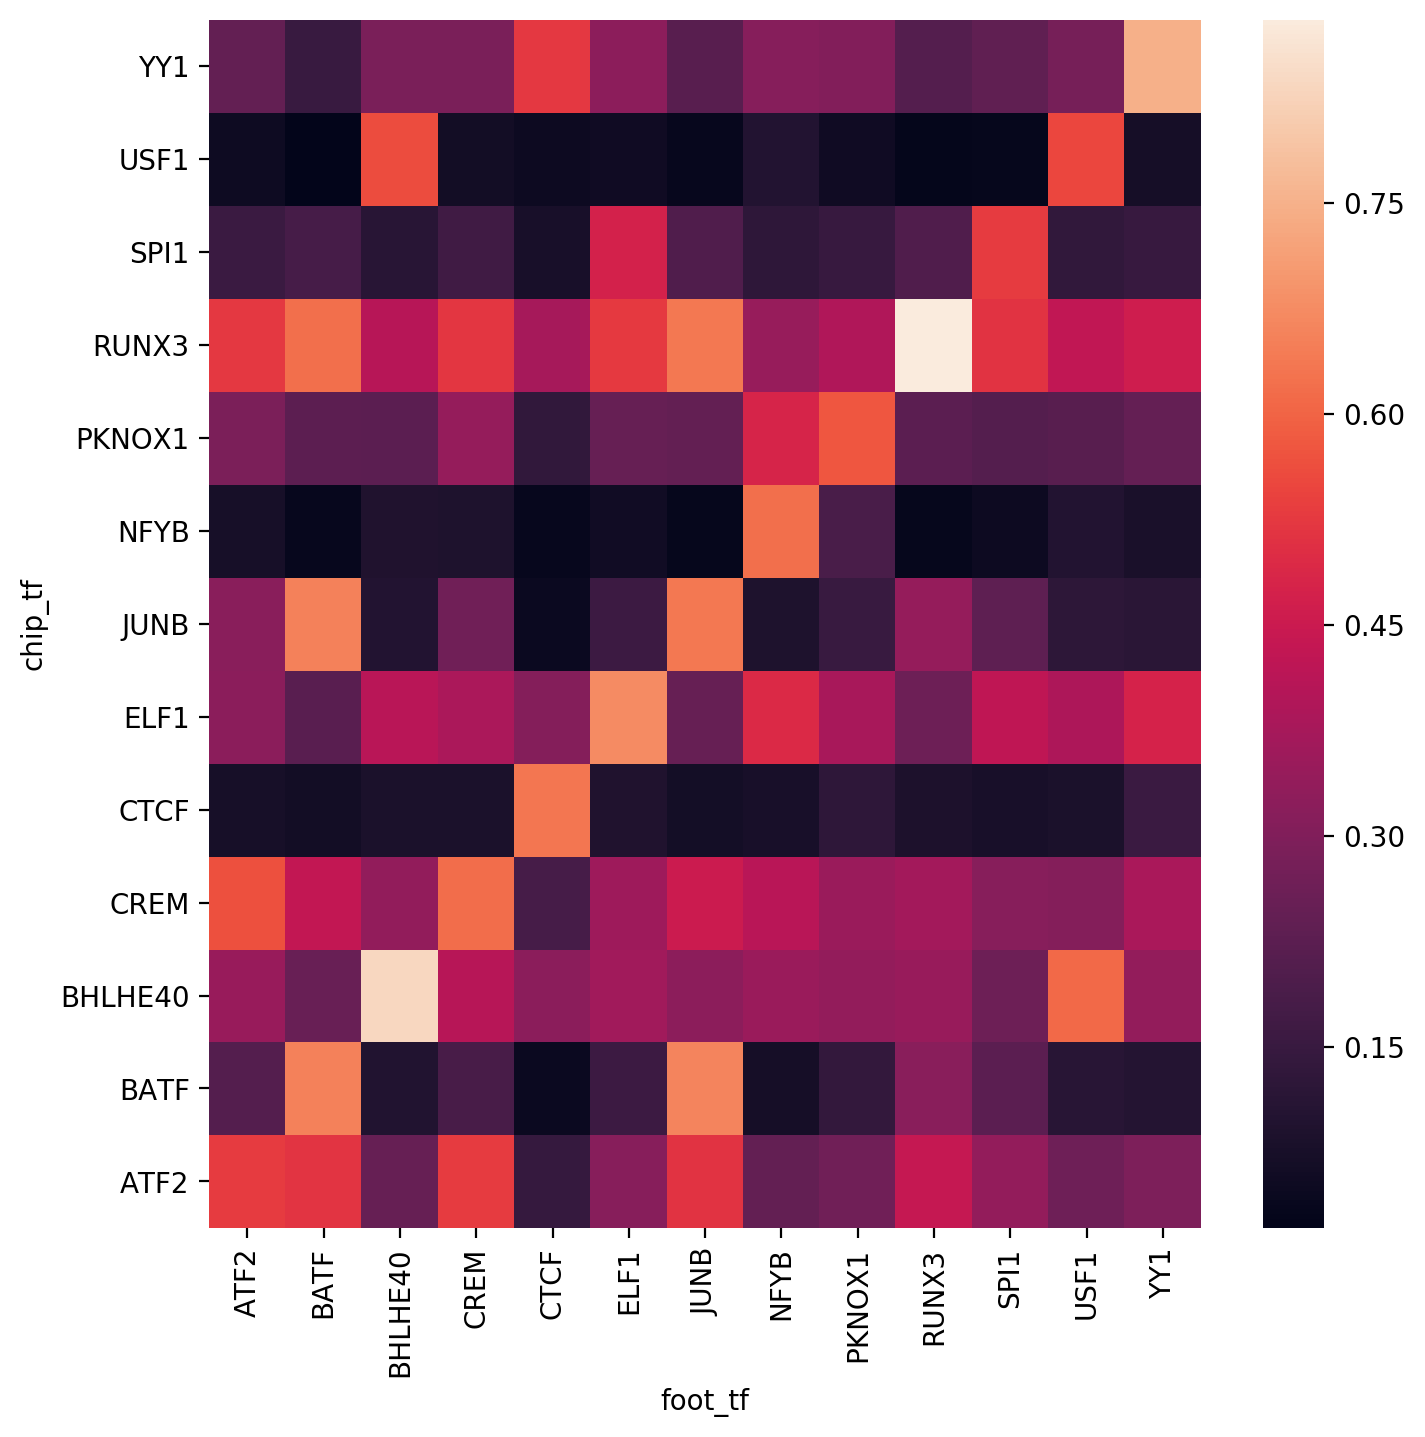

In [173]:
# fig = plt.figure()
fig,ax = plt.subplots(figsize=(8,8),dpi=200)

ax = sns.heatmap(pairwise_df.pivot('chip_tf','foot_tf',values='PPV'))
ax.set_ylim(0,len(pairwise_df.pivot('chip_tf','foot_tf',values='PPV')))#-0.5, -0.5)
plt.savefig(os.path.join(save_dir, 'foot_chip_PPV_good_pairs.pdf'),pad_inches=0.4)

In [133]:
%%time
results_dict_pair_all = {}
for idx, row in chip_annon_df_footsel.iterrows():
#     if row.id not in id_to_run_pairwise_on:
#         continue
    print(idx,row.tf,row['File accession'])
    # get chip file
    chip_file = row.file_path
    chip_name = os.path.basename(chip_file).split('.bed.gz')[0]
    chip_bed = pybedtools.BedTool(chip_file).sort().merge()
    chip_atac_bed = chip_bed.intersect(atac_bed)
    
    
    for foot_id in fileacc_to_tfid.values():
#         if foot_id not in id_to_run_pairwise_on:
#             continue
        
        # get selected footprinting      
        foot_bed_tfsel = foot_id_to_foot_bed[foot_id]

        num_chip_peaks = len(chip_bed)
        num_chip_atac_peaks = len(chip_atac_bed)
        num_footprints = len(foot_bed_tfsel)

        TP = (chip_atac_bed+foot_bed_tfsel).count() # A
        FP = (foot_bed_tfsel-chip_atac_bed).count() # B
        FN = (chip_atac_bed-foot_bed_tfsel).count() # C
        TN = foot_bed_tfsel.cat(chip_atac_bed).count() # D

        sens = TP/(TP+FN)
        spec = TN/(TN+FP)
        PPV = TP/(TP+FP)
        FDR = 1- PPV
        NPV = TN/(TN+FP)
        acc = (TP+TN)/(TP+TN+FP+FN)

        results_dict_pair[(chip_name,  foot_id)] = {'chip_id':row.id,'chip_tf': row.tf,  'foot_tf':tfid_to_tf[foot_id], 'foot_id':foot_id,
#                                 'num_chip_peaks':num_chip_peaks, 'num_chip_atac_peaks':num_chip_atac_peaks,'num_footprints':num_footprints,
#                                 'TP':TP, 'FP':FP,'FN':FN,'TN':TN,
                    'sens':sens,'spec':spec,'PPV':PPV,'NPV':NPV,'FDR':FDR,'acc':acc
        }
#     z = {**x, **y}

sens      spec       PPV       acc
chip_tf foot_tf                                        
ATF2    ATF2     0.026693  0.977178  0.528033  0.512483
        BATF     0.027105  0.975674  0.514677  0.513117
        BHLHE40  0.010409  0.969889  0.246341  0.503581
        CREM     0.016438  0.985716  0.528146  0.507813
        CTCF     0.019839  0.902937  0.141962  0.507884
...                   ...       ...       ...       ...
YY1     PKNOX1   0.011290  0.975418  0.304009  0.505453
        RUNX3    0.016460  0.944663  0.209253  0.507662
        SPI1     0.038586  0.899496  0.235487  0.516256
        USF1     0.012531  0.969887  0.282386  0.504583
        YY1      0.025972  0.991423  0.748510  0.512864

[169 rows x 4 columns]

In [67]:
# # testing

# chip_file = '../data/raw/tf_chip/GM12878/ENCFF363BLT.bed.gz'
# chip_name = os.path.basename(chip_file).split('.bed.gz')[0]
# chip_bed = pybedtools.BedTool(chip_file).sort().merge()
# print(len(chip_bed))

# foot_df_tfsel = foot_df[foot_df.name==fileacc_to_tfid[chip_name]]
# foot_bed_tfsel = pybedtools.BedTool.from_dataframe(foot_df_tfsel).sort()
# print(len(foot_bed_tfsel))

In [68]:
# TP = (chip_bed+foot_bed_tfsel).count() # A
# FP = (foot_bed_tfsel-chip_bed).count() # B
# FN = (chip_bed-foot_bed_tfsel).count() # C
# TN = foot_bed_tfsel.cat(chip_bed).count() # D

# sens = TP/(TP+FN)
# spec = TN/(TN+FP)
# PPV = TP/(TP+FP)
# FDR = 1- PPV
# NPV = TN/(TN+FP)
# acc = (TP+TN)/(TP+TN+FP+FN)

# metrics_dict={'TP':TP, 'FP':FP,'FN':FN,'TN':TN,
#                 'sens':sens,'spec':spec,'PPV':PPV,'NPV':NPV,'FDR':FDR,'acc':acc
#     }
# metrics_dict
# # foot_with_chip = foot_bed_tfsel.intersect(chip_bed,wa=True,wb=True).to_dataframe(header=None)
# # foot_with_chip.columns = [ 'chr_foot','start_foot','end_foot','tfid','score','strand','chr_chip','start_chip','end_chip']
# # print(foot_with_chip[ ['chr_chip','start_chip','end_chip']].drop_duplicates().shape[0])
# # foot_with_chip

In [65]:
# chip_with_foot = chip_bed.intersect(foot_bed_tfsel,wa=True,wb=True).to_dataframe(header=None)
# chip_with_foot.columns = ['chr_chip','start_chip','end_chip', 'chr_foot','start_foot','end_foot','tfid','score','strand']
# num_chip_with_foot = chip_with_foot[ ['chr_chip','start_chip','end_chip']].drop_duplicates().shape[0]
# chip_with_foot

In [69]:
# # the number o atac peaks that have 
# chip_atac_bed = chip_bed.intersect(atac_bed, wo=True, sorted=True, f=0.5,names='atac').merge()
# print(len(chip_atac_bed))
# chip_atac_df = chip_atac_bed.to_dataframe(header=None)
# chip_atac_df
